# Insuline simulator

The goal of this project is to improve the quality of life for individuals with type 1 diabetes. We focus on simulating food and carbohydrate intake to automatically deliver the appropriate insulin dose when needed, ensuring that glucose levels are consistently kept within a healthy range.
### System Methodology

To train our RL agent safely and efficiently, we have constructed a digital simulation environment using the `simglucose` library, a validated simulator that models the complex dynamics of glucose in the human body. The key to our system is a "wrapper" class that adapts this simulation to the standardized interface of `gymnasium`, the industry standard for RL environments.

This environment defines the "playground" for our AI and is composed of the following elements:

1.  **Environment Construction**: Upon starting a simulation, the system configures a complete virtual scenario. A virtual patient is selected from a set of predefined profiles, each with its own physiological parameters. Next, the simulated devices are initialized: a Continuous Glucose Monitor (CGM), which acts as the agent's "eyes," and an insulin pump, which serves as its "hands." Finally, a meal scenario is introduced to simulate carbohydrate intake.

2.  **Interaction and Learning**: The training occurs in discrete 15-minute cycles. In each step:
    * The agent **observes** the current glucose level, $G(t)$.
    * Based on this observation, it decides on an **action**: the insulin dose to be administered.
    * The environment receives this action, the simulation advances by 15 minutes, and `simglucose` calculates the new glucose level, $G(t+15)$, accounting for both the injected insulin and the effect of meals.
    * The agent receives a **reward**: a positive score is awarded for maintaining glucose within the target range, while states of hypoglycemia and hyperglycemia are heavily penalized.

Through thousands of these "trial-and-error" cycles, the agent learns to associate specific glucose levels with optimal insulin doses, with the ultimate goal of maximizing its cumulative reward and, therefore, maintaining the virtual patient's glycemic stability. This project represents a step towards more intelligent, dynamic, and personalized diabetes control systems.

### Why simglucose?

This is the main engine of the simulation. It provides the mathematical models for:

* **T1DPatient:** Simulates the physiology of a patient with type 1 diabetes (how their body reacts to insulin, carbohydrates, etc.).
* **CGMSensor:** Simulates a Continuous Glucose Monitor (CGM), which measures the patient's glucose level.
* **InsulinPump:** Simulates an insulin pump, the device that administers insulin.
* **RandomScenario:** Creates random scenarios (meals at unexpected times) to make the simulation more realistic.


In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from simglucose.envs.simglucose_gym_env import T1DSimEnv
from simglucose.simulation.scenario import Scenario

In [2]:
def discretize_glucose(glucose, bins=[70, 120, 180]):
    # Bins: <70, 70-120, 120-180, >180
    if glucose < bins[0]:
        return 0
    elif glucose < bins[1]:
        return 1
    elif glucose < bins[2]:
        return 2
    else:
        return 3

In [3]:
action_space = np.arange(0, 6.5, 0.5) # e.g. 0, 0.5, ..., 6
n_actions = len(action_space)
n_states = 4 # Based on discretize_glucose

In [4]:
def reward_fn(glucose):
    if glucose < 70:
        return -100 * (70 - glucose)
    elif glucose > 180:
        return -100 * (glucose - 180)
    else:
        return 1000

In [5]:
class TDControlAgent:
    def __init__(self, n_states, n_actions, gamma=0.99, lr=0.1, alg="qlearning"):
        self.gamma = gamma
        self.lr = lr
        self.n_states = n_states
        self.n_actions = n_actions
        self.Qvalues = np.zeros((n_states, n_actions))
        self.alg = alg # "sarsa" or "qlearning"
        
    def get_action_epsilon_greedy(self, s, eps):
        if np.random.rand() < eps:
            return np.random.randint(self.n_actions)
        else:
            best_value = np.max(self.Qvalues[s])
            best_actions = (self.Qvalues[s] == best_value)
            prob_actions = best_actions / np.sum(best_actions)
            return np.random.choice(self.n_actions, p=prob_actions)
        
    def single_step_update(self, s, a, r, new_s, new_a=None, done=False):
        if self.alg == "sarsa":
            if done:
                deltaQ = r - self.Qvalues[s, a]
            else:
                deltaQ = r + self.gamma * self.Qvalues[new_s, new_a] - self.Qvalues[s, a]
        elif self.alg == "qlearning":
            if done:
                deltaQ = r - self.Qvalues[s, a]
            else:
                deltaQ = r + self.gamma * np.max(self.Qvalues[new_s]) - self.Qvalues[s, a]
        else:
            raise ValueError("Unknown algorithm")
        self.Qvalues[s, a] += self.lr * deltaQ

In [6]:
env = T1DSimEnv()
agent = TDControlAgent(n_states=n_states, n_actions=n_actions, gamma=0.99, lr=0.1, alg="qlearning") # or "sarsa"
epsilon = 0.1
num_episodes = 1000
performance = np.zeros(num_episodes)

In [7]:
for episode in range(num_episodes):
    # reset() returns only the observation
    obs = env.reset() 
    
    # # Access the scenario generator from the underlying environment
    # scenario_generator = env.env.scenario
    
    # print(f"--- Episode {episode + 1} ---")
    # print("Scenario of meals generated:")
    
    # # Access the 'meal' key from the scenario dictionary
    # print(scenario_generator.scenario['meal'])

    if isinstance(obs, tuple):
        obs = obs[0]
    # Extract glucose value robustly
    if hasattr(obs, "CGM"):
        glucose = obs.CGM
    elif isinstance(obs, dict) and 'CGM' in obs:
        glucose = obs['CGM']
    elif isinstance(obs, (np.ndarray, list)):
        glucose = obs[0]
    elif isinstance(obs, (float, int)):
        glucose = obs
    else:
        raise ValueError(f"Unknown observation format: {type(obs)}")

    s = discretize_glucose(glucose)
    a = agent.get_action_epsilon_greedy(s, epsilon)

    done = False
    while not done:
        insulin_dose = action_space[a]
        step_result = env.step(insulin_dose)
        if isinstance(step_result, tuple) and len(step_result) == 4:
            next_obs, _, done, info = step_result
        else:
            next_obs = step_result
            done = False

        if hasattr(next_obs, "CGM"):
            next_glucose = next_obs.CGM
        elif isinstance(next_obs, dict) and 'CGM' in next_obs:
            next_glucose = next_obs['CGM']
        elif isinstance(next_obs, (np.ndarray, list)):
            next_glucose = next_obs[0]
        elif isinstance(next_obs, (float, int)):
            next_glucose = next_obs
        else:
            raise ValueError(f"Unknown observation format: {type(next_obs)}")

        r = reward_fn(next_glucose)
        performance[episode] += r
        new_s = discretize_glucose(next_glucose)
        if agent.alg == "sarsa":
            new_a = agent.get_action_epsilon_greedy(new_s, epsilon)
            if new_s <2:
                new_a=0
            agent.single_step_update(s, a, r, new_s, new_a, done)
            s, a = new_s, new_a
        else:  # Q-learning
            agent.single_step_update(s, a, r, new_s, done=done)
            s = new_s
            if new_s <2:
                new_a=0
            a = agent.get_action_epsilon_greedy(s, epsilon)

print("Training complete. Use agent.Qvalues for the learned policy.")

Training complete. Use agent.Qvalues for the learned policy.


In [8]:
np.save('q_table.npy', agent.Qvalues)
print("Model (Table Q) saved correctly in 'q_table.npy'!")

Model (Table Q) saved correctly in 'q_table.npy'!


Scenario of meals generated:
{'time': [np.float64(492.0), np.float64(689.0), np.float64(1048.0)], 'amount': [51, 61, 85]}


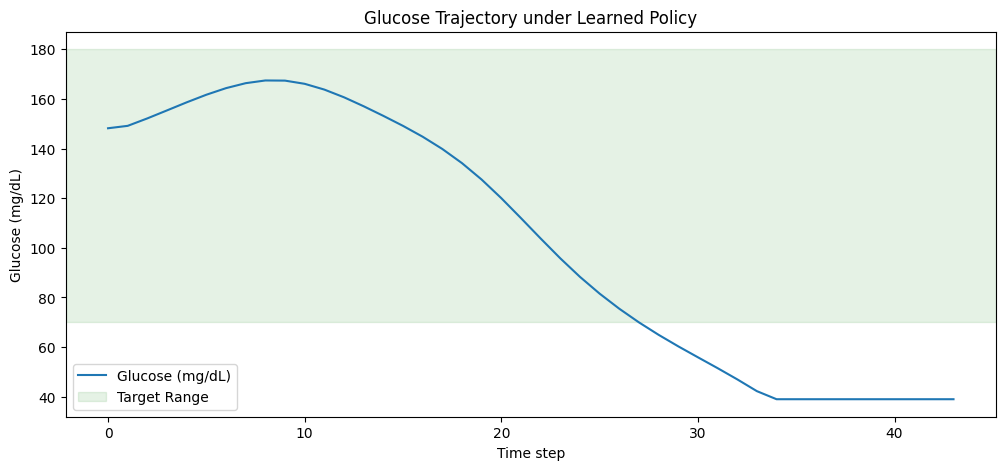

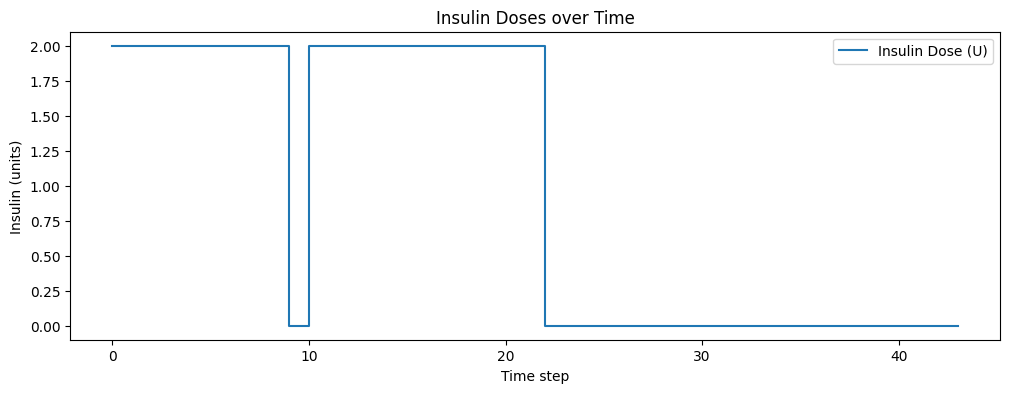

In [20]:
import matplotlib.pyplot as plt

agent_test = TDControlAgent(n_states=n_states, n_actions=n_actions)
agent_test.Qvalues = np.load('q_table.npy')
# Set epsilon=0 for greedy policy (pure exploitation)
epsilon_eval = 0.1

# Start a new episode
obs = env.reset()

# # Access the scenario generator from the underlying environment
scenario_generator = env.env.scenario

print("Scenario of meals generated:")

# Access the 'meal' key from the scenario dictionary
print(scenario_generator.scenario['meal'])
if isinstance(obs, tuple):
    obs = obs[0]
if hasattr(obs, "CGM"):
    glucose = obs.CGM
elif isinstance(obs, dict) and 'CGM' in obs:
    glucose = obs['CGM']
elif isinstance(obs, (np.ndarray, list)):
    glucose = obs[0]
elif isinstance(obs, (float, int)):
    glucose = obs
else:
    raise ValueError(f"Unknown observation format: {type(obs)}")

s = discretize_glucose(glucose)
a = agent_test.get_action_epsilon_greedy(s, epsilon_eval)
done = False

# Lists to record data
G_t = [glucose]
I_t = [action_space[a]]
rewards = []
times = [0]
t = 0

while not done:
    insulin_dose = action_space[a]
    step_result = env.step(insulin_dose)
    if isinstance(step_result, tuple) and len(step_result) == 4:
        next_obs, _, done, info = step_result
    else:
        next_obs = step_result
        done = False
    
    if hasattr(next_obs, "CGM"):
        next_glucose = next_obs.CGM
    elif isinstance(next_obs, dict) and 'CGM' in next_obs:
        next_glucose = next_obs['CGM']
    elif isinstance(next_obs, (np.ndarray, list)):
        next_glucose = next_obs[0]
    elif isinstance(next_obs, (float, int)):
        next_glucose = next_obs
    else:
        raise ValueError(f"Unknown observation format: {type(next_obs)}")
    
    r = reward_fn(next_glucose)
    rewards.append(r)
    G_t.append(next_glucose)
    I_t.append(insulin_dose)
    t += 1
    times.append(t)
    
    s = discretize_glucose(next_glucose)
    a = agent_test.get_action_epsilon_greedy(s, epsilon_eval)
    if s < 2:
        a = 0  # Ensure no insulin is given if glucose is below 120

# Plot glucose over time
plt.figure(figsize=(12,5))
plt.plot(times, G_t, label='Glucose (mg/dL)')
plt.axhspan(70, 180, color='green', alpha=0.1, label='Target Range')
plt.xlabel('Time step')
plt.ylabel('Glucose (mg/dL)')
plt.title('Glucose Trajectory under Learned Policy')
plt.legend()
plt.show()

# Optional: Plot insulin doses
plt.figure(figsize=(12,4))
plt.step(times, I_t, label='Insulin Dose (U)', where='post')
plt.xlabel('Time step')
plt.ylabel('Insulin (units)')
plt.title('Insulin Doses over Time')
plt.legend()
plt.show()